In [1]:
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
import cv2
import tensorflow as tf
from tensorflow import keras

2023-06-20 13:44:48.801741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 13:44:53.429334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/smitra/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/smitra/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-06-20 13:44:53.429711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7

In [2]:
import os

os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

!git clone https://github.com/yiskw713/ScoreCAM.git

fatal: destination path 'ScoreCAM' already exists and is not an empty directory.


In [3]:
#Importing the content of the repo
import sys
sys.path.append('/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/')
%cd /content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/ScoreCAM

/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/ScoreCAM


In [4]:
%matplotlib inline

import skimage.transform
import torch.nn as nn
from ScoreCAM import cam

from matplotlib.pyplot import imshow
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

#Using ResNet for Image Classication

In [5]:
# Using a pretrained model for image classification
model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Loading Test Image

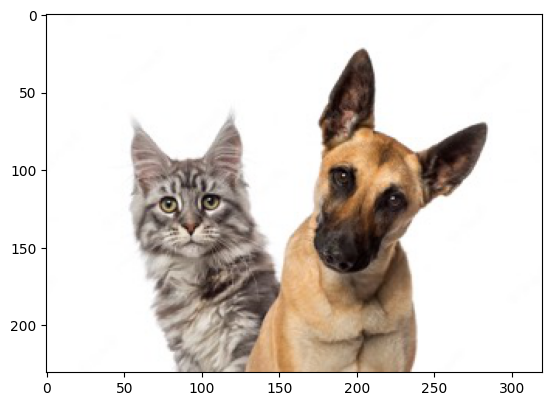

In [6]:
#Loading the original image

#image_path = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
image_path = '/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/dog_cat_3.jpeg'
#image_path = "/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/dog_cat_4.jpg"
imshow(Image.open(image_path))

#Preprocessing the Test Image

In [7]:
# preprocessing the test image

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [8]:
# the target layer you want to visualize

target_layer = model.layer4[1].conv2
print(target_layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [9]:
# Using the SmoothGradCAM logic to build the saliency map

wrapped_model1 = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)
wrapped_model2 = ScoreCAM(model, target_layer)

#Applying patch to the Test Image

In [10]:
#Creating the patch
PATCH_SIZE = 60
def apply_grey_patch(path, image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0
    img = keras.preprocessing.image.array_to_img(patched_image)
    print(path)
    img.save(path)
    print(np.shape(patched_image))
    return patched_image

In [11]:
#Putting the patch over the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)


i = 0
# Iterate the patch over the image
for top_left_x in range(0, image.shape[0], PATCH_SIZE):
    for top_left_y in range(0, image.shape[1], PATCH_SIZE):
        # Apply the patch and display the image
        path = 'occluded_img_'+str(i)+'.jpg'
        i+=1
        patched_image = apply_grey_patch(path,image, top_left_x, top_left_y, PATCH_SIZE)
        patched_image = patched_image.astype('float32') / 255.0

occluded_img_0.jpg
(224, 224, 3)
occluded_img_1.jpg
(224, 224, 3)
occluded_img_2.jpg
(224, 224, 3)
occluded_img_3.jpg
(224, 224, 3)
occluded_img_4.jpg
(224, 224, 3)
occluded_img_5.jpg
(224, 224, 3)
occluded_img_6.jpg
(224, 224, 3)
occluded_img_7.jpg
(224, 224, 3)
occluded_img_8.jpg
(224, 224, 3)
occluded_img_9.jpg
(224, 224, 3)
occluded_img_10.jpg
(224, 224, 3)
occluded_img_11.jpg
(224, 224, 3)
occluded_img_12.jpg
(224, 224, 3)
occluded_img_13.jpg
(224, 224, 3)
occluded_img_14.jpg
(224, 224, 3)
occluded_img_15.jpg
(224, 224, 3)


#Implementing SmoothGradCAM++

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 225	 probability 0.6868122816085815
malinois


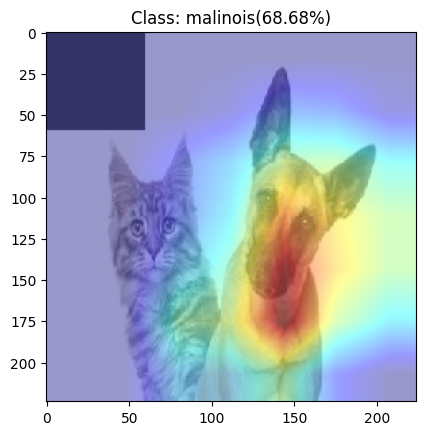

In [12]:
fig, ax = plt.subplots()

for i in range(0,1):
  img = tf.keras.preprocessing.image.load_img('occluded_img_'+str(i)+'.jpg')
  tensor = preprocess(img) # converting image to tensor
  tensor = tensor.unsqueeze(0) # reshape 4D tensor (N, C, H, W); N:batch size, C: Channels, H: Height of tensor, W: Width of tensor
  cam, idx, prob = wrapped_model1(tensor)
  print(idx2label[idx])
  img = reverse_normalize(tensor)
  heatmap = visualize(img, cam)
  heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
  ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
  ax.set_title(f"Class: {idx2label[idx]}({prob*100:.2f}%)")
  fig.savefig(f"/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/Saliency_Map/{i}_{idx2label[idx]}.jpg")
  #save_image(heatmap, '/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/Saliency_Map/'+str(i)+'_{}.jpeg'.format(idx2label[idx])) #.set_title(f"Class: {idx2label[idx]} ({prob*100:.2f}%)"))

#Implementing ScoreCAM

In [13]:
# fig, ax = plt.subplots()

# for i in range(0,16):
#   img = tf.keras.preprocessing.image.load_img('occluded_img_'+str(i)+'.jpeg')
#   tensor = preprocess(img) # converting image to tensor
#   tensor = tensor.unsqueeze(0) # reshape 4D tensor (N, C, H, W); N:batch size, C: Channels, H: Height of tensor, W: Width of tensor
#   cam, idx = wrapped_model2(tensor)
#   print(idx2label[idx])
#   with torch.no_grad():
#     output = model(tensor)
#     perturbed_class = torch.argmax(output).item()
#     prob = torch.softmax(output, dim=1)[0, perturbed_class].item()
#   img = reverse_normalize(tensor)
#   heatmap = visualize(img, cam)
#   heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
#   ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
#   ax.set_title(f"Class: {idx2label[idx]}({prob*100:.2f}%)")
#   fig.savefig(f"/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/Saliency_Map/{i}_{idx2label[idx]}.jpeg")
#   #save_image(heatmap, '/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/Saliency_Map/'+str(i)+'_{}.jpeg'.format(idx2label[idx])) #.set_title(f"Class: {idx2label[idx]} ({prob*100:.2f}%)"))

#Adding Gaussian Noise to the Test Image

In [14]:
# #Adding noise to the original image

# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# mean = 0
# variance = 1.5
# stddev = variance ** 0.5
# noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
# image = cv2.add(image, noise)

# imshow(image)